# クラスタリング

## 【事前準備】

In [1]:
# scikit-learnの「set_config(display="diagram")」を使用するため、scikitlearnを最新verに更新
# !pip install scikit-learn==0.23.2 --target drive/My\ Drive/MyModule
# !pip install scikit-learn==0.23.2
# !pip list
## Google Drive上にインストールしたモジュールのインポート##
import sys
sys.path.append('/content/drive/My Drive/MyModule')

In [2]:
## モジュールのインポート ##
# 一般
import random
import math
# データ分析
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
# 決定木可視化のためのツール
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
# その他
from google.colab import drive #GoogleDriveモジュール
drive.mount('/content/drive') #GoogleDriveのマウント

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## 【実装】

### ●ScratchKMeansクラスの定義

In [3]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装
    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    random_state : float
      乱数シート値
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.center_point : 次の形のndarray, shape (n_clusters, n_features)
      中心点
    self.r : 次の形のndarray, shape (n_samples, n_clusters)
      各データ点Xnが属するクラスタ番号を示す配列。
      該当するクラスタ番号の列を1にセットし、それ以外の列は0にセット。
    """
    def __init__(self, n_clusters=3, n_init=1, max_iter=10, tol=10, random_state=None, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose
        self.center_point = np.array([])
        self.r = np.array([])

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        n_samples = X.shape[0]    # サンプル数

        # データ点の中から中心点を選択する際に使用するインデックスのリストを初期化
        np.random.seed(self.random_state)   #乱数シードを設定
        self.index_list = list(range(n_samples))   # 0 ～ n_samples-1 までのリスト
        np.random.shuffle(self.index_list)   # リストをシャッフル

        sse_temp1 = np.inf    # SSE（暫定値）
        sse_temp3 = np.inf    # SSE（前回値との比較用）

        # self.n_initの回数だけ中心点のリセットと学習を行い、
        # その中で最小のSSEが得られた時のパラメータを採用する
        for i in range(self.n_init):
            # 学習に使用する各種変数（中心点、r配列）を初期化
            self._init_variables(X, i)

            # イテレーションの回数だけループ
            for j in range(self.max_iter):
                # 各データ点X_iを中心点に割り当て
                self._assign_data_to_center_point(X, self.r)
                # 各クラスタの中心点を更新
                self._update_center_point(X)
                # SSEを算出
                sse_temp2 = self._calculate_sse(X)
                # SSEが前回から変化してなければ処理終了
                if (sse_temp2 == sse_temp3):
                    break
                else:
                    sse_temp3 = sse_temp2
                # SSEが閾値を下回ったら処理終了
                if (sse_temp2 < self.tol):
                    break

            # 今回算出したSSEがこれまでの値よりも小さければ採用
            if (sse_temp2 < sse_temp1):
                # デバッグ情報出力
                if self.verbose: print("今回: {}, 前回:{} ⇒ 今回の値で上書き".format(sse_temp2, sse_temp1))
                # 学習した中心点、r配列、SSEをローカル変数に一旦退避
                center_point = self.center_point.copy()
                r = self.r.copy()
                sse_temp1 = sse_temp2
            else:
                # デバッグ情報出力
                if self.verbose: print("今回: {}, 前回:{} ⇒ 前回の値を維持".format(sse_temp2, sse_temp1))
        
        # 最小のSSEが得られた時のパラメータでインスタンス変数を更新
        self.center_point = center_point.copy()
        self.r = r.copy()
        self.cluster_num = np.where(self.r == 1)[1]    # 各データ点が属するクラスタ番号のリストを取得
        self.sse = sse_temp1

        # デバッグ情報出力
        if self.verbose:
            print("■学習完了")
            print("self.r:\n{}".format(self.r))
            print("self.cluster_num:{}".format(self.cluster_num))
            print("self.center_point:\n{}".format(self.center_point))
            print("self.sse:\n{}".format(self.sse))
        return

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
            検証データのクラスタ番号の推定値
        """
        n_samples = X.shape[0]    # 特徴量の数

        # 配列r（各データ点Xnが属するクラスタ番号を示す配列）の初期化
        r = np.zeros((n_samples, self.n_clusters))   # (サンプル数 x クラスタ数)の配列
        r[:, 0] = 1  # 暫定的に全サンプルのクラスタ番号を0に設定

        self._assign_data_to_center_point(X, r)

        y_pred = np.where(r == 1)[1]    # 各データ点が属するクラスタ番号のリストを取得

        return  y_pred

    def _init_variables(self, X, learning_num=0):
        """
        学習に使用する各種変数を初期化する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            特徴量データ
        Returns
        -------
        None
        """
        n_samples = X.shape[0]    # 特徴量の数
        
        max_learning_num = int(n_samples / self.n_clusters) - 1  # 学習回数の上限
        # 学習回数が上限を超過した場合は強制的に上限値に修正（index_listのインデックス範囲超過の防止のため）
        if (learning_num > max_learning_num):
            learning_num = max_learning_num

        # 中心点の初期化
        index_start = self.n_clusters * learning_num   # 始点
        index_end = index_start + self.n_clusters   # 終点
        index_list = self.index_list[index_start : index_end]   # クラスタ数だけリストから抽出
        self.center_point = X[index_list, :]    # データセットXの中から中心点の初期値として使用するものを選択

        # 配列r（各データ点Xnが属するクラスタ番号を示す配列）の初期化
        self.r = np.zeros((n_samples, self.n_clusters))   # (サンプル数 x クラスタ数)の配列
        self.r[:, 0] = 1  # 暫定的に全サンプルのクラスタ番号を0に設定

        # デバッグ情報出力
        if self.verbose:
            print("■各変数の初期化完了（{}回目）".format(learning_num + 1))
            print("self.r:\n{}".format(self.r))
            print("self.center_point:\n{}".format(self.center_point))
            print("index_list: {}".format(index_list))
        return

    def _calculate_sse(self, X):
        """
        SSEを計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            特徴量データ
        Returns
        -------
        sse : float
            SSE（クラスタ内誤差平方和／Sum of Squared Errors）
        """
        n_samples = X.shape[0]    # 特徴量の数
        sse = 0   # SSE

        #  N K
        # ΣΣr_nk|X_n-μ_k|^2 を計算
        for n in range(n_samples):
            for k in range(self.n_clusters):
                # sse += self.r[n, k] * ((X[n] - self.center_point[k])**2).sum()
                sse += self.r[n, k] * (X[n] - self.center_point[k]) @ (X[n] - self.center_point[k])
        # デバッグ情報出力
        if self.verbose:
            print("sse: {}".format(sse))
        return sse

    def _assign_data_to_center_point(self, X, r):
        """
        各データ点X_i (i=1～n)が最も近い中心点μ_kに割り当たるよう、r配列を更新する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            特徴量データ
        r : 次の形のndarray, shape (n_samples, self.n_clusters)
            r配列
        Returns
        -------
        None
        """
        n_samples = X.shape[0]    # 特徴量の数

        for n in range(n_samples):
            norm = np.inf   # データ点X_nと中心点μ_kとの距離を∞で初期化
            for k in range(self.n_clusters):
                # データ点X_nと中心点μ_kとの距離を計算
                norm_temp = np.sqrt((X[n] - self.center_point[k]) @ (X[n] - self.center_point[k]))
                # これまで算出した距離よりも小さければ採用
                if (norm_temp < norm):
                    norm = norm_temp    # 距離
                    cluster_num = k    # クラスタ番号
            # データ点X_nに最も近かった中心点のクラスタ番号に更新
            r[n] = np.zeros(self.n_clusters)  # 一旦全て0クリア
            r[n, cluster_num] = 1    # 該当するクラスタ番号の列のみ1にセット

    def _update_center_point(self, X):
        """
        同一のクラスタ番号に属する各データ点X_iの中心点を決め、その値でself.center_pointを更新する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            特徴量データ
        Returns
        -------
        None
        """
        n_samples = X.shape[0]    # 特徴量の数

        for k in range(self.n_clusters):
            index_list = np.where(self.r[:, k] == 1)    # k番目のクラスタに属するデータX_iのインデックスのリストを取得
            self.center_point[k] = X[index_list].mean(axis=0)   # k番目のクラスタに属するデータ点の中心点を更新

### ●クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しています。


このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。

In [24]:
X, y = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
X_y = np.concatenate([X, y.reshape(y.shape[0], 1)], axis=1)
df_blobs = pd.DataFrame(data=X_y, columns=["X0", "X1", "y"])

pd.set_option("display.max_rows", 50)    #行数の表示上限を指定
display(df_blobs)

#データセットを学習用と検証用に分割
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, train_size = 0.75, random_state=0)

,X0,X1,y
0,0.720868,3.713471,0.0
1,-1.894684,7.968985,3.0
2,1.356789,4.364625,0.0
3,1.053744,4.492869,0.0
4,1.591415,4.904977,0.0
...,...,...,...
95,-1.800447,7.861543,3.0
96,-1.649961,7.490685,3.0
97,-1.561025,3.774554,2.0
98,-0.787826,7.994824,3.0


,X0,X1,y
X0,1.000000,-0.595549,-0.726184
X1,-0.595549,1.000000,0.555085
y,-0.726184,0.555085,1.000000


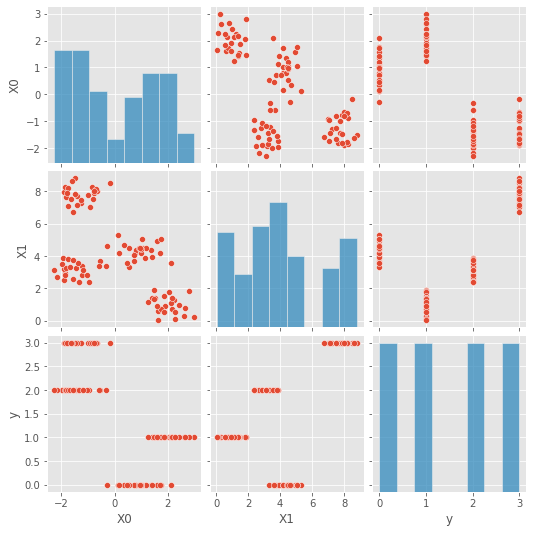

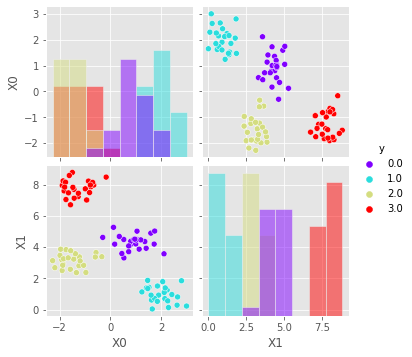

In [5]:
#相関係数
display(df_blobs.corr())

#散布図行列を作成
sns.pairplot(df_blobs, diag_kind="hist", palette="rainbow");
sns.pairplot(df_blobs, hue="y", diag_kind="hist", palette="rainbow");

### ●動作確認【問題1～5】

In [6]:
clf = ScratchKMeans(n_clusters=4, n_init=1, max_iter=5, tol=10, random_state=0, verbose=True)

np.set_printoptions(threshold=10)    #ndarrayの要素の表示数上限を設定

##【問題1】_init_variablesメソッドの動作確認 ##
print("##【問題1】_init_variablesメソッドの動作確認 ##")
clf.fit(X)
clf._init_variables(X)    # 中心点を初期化（中心点の初期位置をランダムに設定）
print("clf.center_point")
print(clf.center_point)
print("\n")


##【問題2】_calculate_sseメソッドの動作確認 ##
print("##【問題2】_calculate_sseメソッドの動作確認 ##")
sse = clf._calculate_sse(X)
print("sse")
print(sse)
print("\n")

# 【問題3】_assign_data_to_center_pointメソッドの動作確認
print("##【問題3】_assign_data_to_center_pointメソッドの動作確認 ##")
clf._assign_data_to_center_point(X, r=clf.r)
print("clf.r")
print(clf.r)
print("\n")

# 【問題4】_update_center_pointメソッドの動作確認
print("##【問題4】_update_center_pointメソッドの動作確認 ##")
clf._update_center_point(X)
print("clf.center_point")
print(clf.center_point)
print("\n")

# 【問題5】fitメソッドの動作確認
print("##【問題5】fitメソッドの動作確認 ##")
clf.fit(X)
print("clf.center_point")
print(clf.center_point)
print("\n")
print("clf.r")
print(clf.r)
print("\n")
print("clf.sse")
print(clf.sse)
print("\n")

##【問題1】_init_variablesメソッドの動作確認 ##
■各変数の初期化完了（1回目）
self.r:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
self.center_point:
[[-0.565433    3.65813966]
 [ 1.60161834  0.92363636]
 [ 1.35678894  4.36462484]
 [-1.26041884  7.46644456]]
index_list: [26, 86, 2, 55]
sse: 57.669036908725104
sse: 48.63378320706403
sse: 48.63378320706403
今回: 48.63378320706403, 前回:inf ⇒ 今回の値で上書き
■学習完了
self.r:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
self.cluster_num:[2 3 2 ... 0 3 2]
self.center_point:
[[-1.47935679  3.11716896]
 [ 1.99186903  0.96561071]
 [ 0.92578447  4.32475792]
 [-1.26811733  7.76378266]]
self.sse:
48.63378320706403
■各変数の初期化完了（1回目）
self.r:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
self.center_point:
[[-0.565433    3.65813966]
 [ 1.60161834  0.92363636]
 [ 1.35678894  4.36462484]
 [-1.26041884  7.46644456]]
index_list: [26, 86, 2, 55]
c

### ●動作確認【問題6～】

##【問題6】fitメソッド（n_init対応後）の動作確認 ##
■各変数の初期化完了（1回目）
self.r:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
self.center_point:
[[-2.27253281  3.13757811]
 [-1.61803727  8.60696731]
 [ 1.04829186  5.03092408]
 [-1.87418794  2.84306499]]
index_list: [52, 57, 22, 74]
sse: 195.1422664048143
sse: 157.9114556406135
sse: 149.99373536871758
sse: 141.33762105760144
sse: 53.90238052575263
今回: 53.90238052575263, 前回:inf ⇒ 今回の値で上書き
■各変数の初期化完了（2回目）
self.r:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
self.center_point:
[[-1.21986433  3.3789856 ]
 [-0.65424088  7.99393132]
 [-1.497272    8.80022604]
 [-1.6609057   3.31911046]]
index_list: [28, 26, 66, 54]
sse: 185.27560311988725
sse: 151.2294960480722
sse: 148.79155926843163
sse: 148.79155926843163
今回: 148.79155926843163, 前回:53.90238052575263 ⇒ 前回の値を維持
■各変数の初期化完了（3回目）
self.r:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]


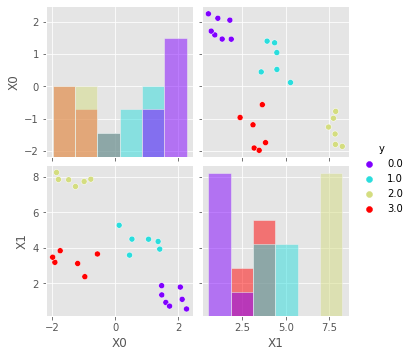

In [7]:
# 【問題6】fitメソッド（n_init対応後）の動作確認
print("##【問題6】fitメソッド（n_init対応後）の動作確認 ##")
clf = ScratchKMeans(n_clusters=4, n_init=10, max_iter=5, tol=10, random_state=0, verbose=True)

X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1

clf.fit(X)
# print("clf.center_point")
# print(clf.center_point)
# print("\n")
# print("clf.r")
# print(clf.r)
# print("\n")
# print("clf.sse")
# print(clf.sse)
# print("\n")

print("\n")

# 【問題7】predictメソッドの動作確認
print("##【問題7】predictメソッドの動作確認 ##")
yt_predict = clf.predict(Xt)

# Xtとytを結合してDataFrame化
Xt_yt_predict = np.concatenate([Xt, yt_predict.reshape(yt.shape[0], 1)], axis=1)
df_blobs_test = pd.DataFrame(data=Xt_yt_predict, columns=["X0", "X1", "y"])

# 散布図行列を作成
# sns.pairplot(df_blobs_test, diag_kind="hist", palette="rainbow");
sns.pairplot(df_blobs_test, hue="y", diag_kind="hist", palette="rainbow");

## 【問題1】中心点の初期値を決める
入力されたデータから 
K
 個の中心点 
μ
1
 から 
μ
K
 の初期値を決めるコードを作成してください。
K
 は指定したクラスタ数です。


最もシンプルな初期値の決定方法は、データ点 
X
n
 の中からランダムに 
K
 個選ぶことです。今回はこれを実装してください。


K-meansの学習結果は中心点 
μ
 の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

### 【問題1 解答】
_init_variablesメソッドをクラス内に作成し、入力されたデータから K 個の中心点 μ 1 から μ K の初期値を決めるコードを実装した。

## 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。


K-meansはこのSSEを最小化する 
r
n
k
 と 
μ
k
 を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

 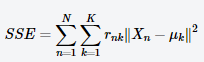


n
 : データ点のインデックス


k
 : クラスタのインデックス


X
n
 : 
n
番目のデータ点


μ
k
 : 
k
番目の中心点


r
n
k
 : データ点
X
n
がクラスタ
k
に所属していたら1、そうでなければ0

### 【問題2 解答】
_calculate_sseメソッドを作成し、その中にSSEを算出する処理を実装した。

## 【問題3】クラスタへの割り当て
すべてのデータ点 
X
n
 を最も近い中心点 
μ
k
 に割り当てるコードを作成してください。


K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル 
p
,
q
 に対しては以下の数式で表現できます。

 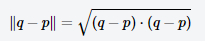

 NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。


numpy.linalg.norm — NumPy v1.17 Manual


中心点 
μ
k
 を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

### 【問題3 解答】
_assign_data_to_center_pointメソッドを新たに用意し、その中に各データ点 X n を最も近い中心点 μ k に割り当てるコードを作成した。

## 【問題4】中心点の移動
中心点 
μ
k
 を 
k
 番目のクラスタに割り当てられるすべてのデータ点 
X
n
 の平均値（重心）に移動するコードを作成してください。


クラスタの割り当て 
r
n
k
 を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

### 【問題4 解答】
_update_center_pointメソッドを新たに用意し、その中に中心点 μ k を各クラスタのデータ点の中心に移動するコードを作成した。

## 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。


次のどれかの条件を満たしたらこれを止めます。


繰り返しが指定した回数に到達する。（雛形では引数max_iter）
中心点 
μ
k
 と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

### 【問題5 解答】
これまでの問題で実装した各メソッドを組み合わせ、所定の条件に達するまで繰り返し実行するようにfitメソッドを実装した。

## 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。


複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 
μ
k
 を保持しておきます。

### 【問題6 解答】
引数n_initで指定した回数だけ初期値を変更して学習し、最小のSSEが得られたときの中心点等を保持するようfitメソッドを修正した。

## 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。


データ点 $X_n$ と学習で決まった中心点 $\mu_k$ に対し、 $SSE$ を最小化する $r_{nk}$ を選ぶ。

具体的には次のことです。


データ点 $X_n$ を最も近い $\mu_k$ に割り当てる。


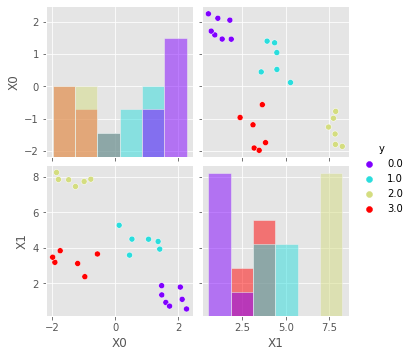

In [8]:
sns.pairplot(df_blobs_test, hue="y", diag_kind="hist", palette="rainbow");

### 【問題7 解答】
検証データに対してどのクラスタに属するのかを推定する処理をpredictメソッド内に実装した。<br>
また、散布図を作成し、各データ点がクラスタ番号ごとに期待通りに振り分けられていることが確認できた。

## 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 $k$ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 $k$ を検討するためのコードを作成してください。


SSEを縦軸、クラスタ数 $k$ を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

### ●エルボー法の関数（SSEを最小にする最適なクラスタ数を導出）

In [9]:
def plot_sse_vs_cluster_num(X, n_clusters_max, n_init=10, max_iter=5, tol=10, random_state=0, verbose=False):
    """
    様々なクラスタ数に対するSSEをグラフにプロットする
    Parameters
    ----------
    n_clusters_max : int
        検証するクラスター数の最大値
    Returns
    ----------
    clf : ScratchKMeansクラスのインスタンス
        最小のSSEが得られた時のk-meansのモデル
    n_clusters : int
        最小のSSEが得られた時のクラスタ数
    """
    clf_list = [] # モデルのインスタンスのリスト
    sse_list = [] # SSEのリスト
    n_clusters_list = list(range(1, n_clusters_max + 1))   # 検証するクラスター数のリスト(1 ～ n_clusters_max)

    # クラスタ数を変化させてSSEを取得
    for k in n_clusters_list:
        clf = ScratchKMeans(k, n_init, max_iter, tol, random_state, verbose)   # クラスタ数=kのインスタンスを生成
        clf_list.append(clf)   # インスタンスをリストに追加
        clf.fit(X)  # 学習
        sse_list.append(clf.sse)      # SSEをリストに追加
        # デバッグ情報出力
        if verbose:
            print("■クラスタ数: {}".format(k))
            print("SSE: {}".format(clf.sse))

    # 最小のSSEが得られた時のクラスタ数kを取得
    index = np.argmin(sse_list)
    n_clusters = n_clusters_list[index]

    # SSE vs クラスタ数kのグラフをプロット
    # fig, ax = plt.subplots(figsize=(15, 10), dpi=50)
    fig, ax = plt.subplots()
    ax.set_title("SSE vs Cluster_num")
    ax.set_xlabel("Cluster number")
    ax.set_ylabel("SSE")
    ax.plot(n_clusters_list, sse_list, color = "blue", label="SSE")
    ax.legend(loc='best') # 凡例を最適位置に表示
    plt.show()

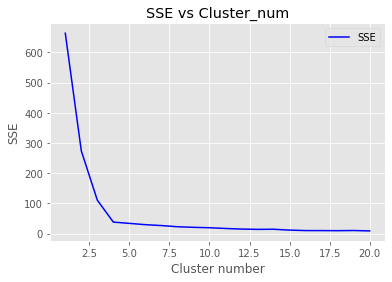

In [33]:
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1

np.set_printoptions(threshold=10)    #ndarrayの要素の表示数上限を設定

# クラスタ数を1～20まで変化させ、それぞれのSSEをグラフにプロット
plot_sse_vs_cluster_num(X, n_clusters_max=20, n_init=10, max_iter=5, tol=10, random_state=0, verbose=False)

### 【問題8 解答】
クラスタ数を1～20まで変化させたときのSSEをグラフに出力した。その結果、クラスタ数を1⇒4まで変化させた時にSSEが急激に減少し、それ以降はSSEが緩やかに下がり続ける結果となった。

## 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 $k$ を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

### ●データセットの準備（卸売業者の顧客データセット／Wholesale customers Data Set）

#### ・データセット取り込み・グラフ化

In [11]:
csv_path = "drive/My Drive/DIVE INTO CODE/Sprint/Sprint7/Wholesale customers data.csv" # ファイル名（パス）を指定する

import pandas as pd
df_wholesale_org = pd.read_csv(csv_path)

# df_wholesale = df_wholesale_org.iloc[:10000, :]   #データ数を削減
df_wholesale = df_wholesale_org.copy()

# データを分割
df_X = df_wholesale.iloc[:, 2:]   # Channel, Region以外の列
df_y = df_wholesale.iloc[:, :2]   # Channel, Region

pd.set_option('display.max_rows', 150)    #最大表示行数を設定
pd.set_option('display.max_columns', 10)   #最大表示列数を設定

display(df_wholesale)

# # データセットを学習用と検証用に分割
# X_train2, X_test2, y_train2, y_test2 = train_test_split(df_X, df_y, train_size = 0.75, random_state=0)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


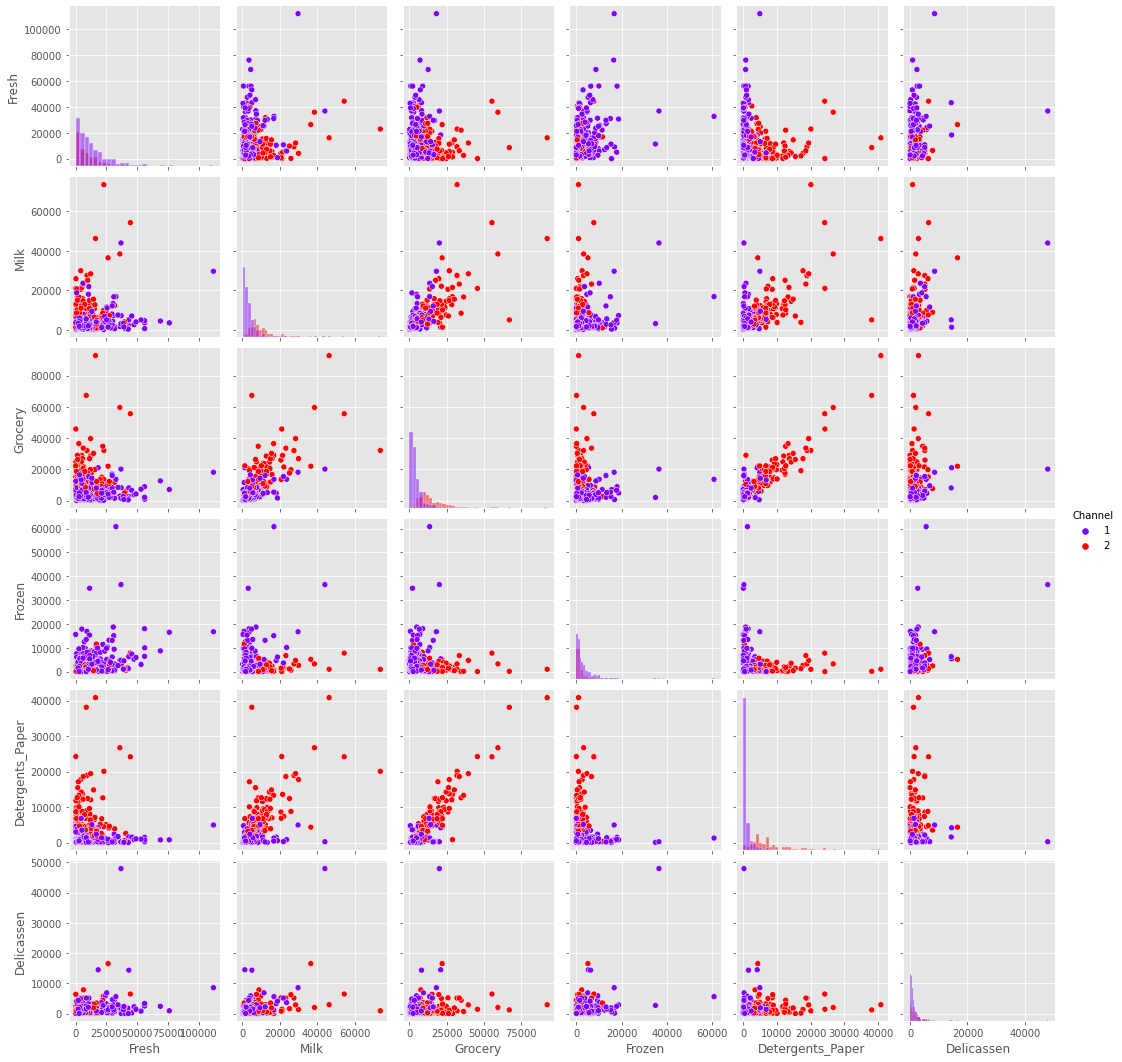

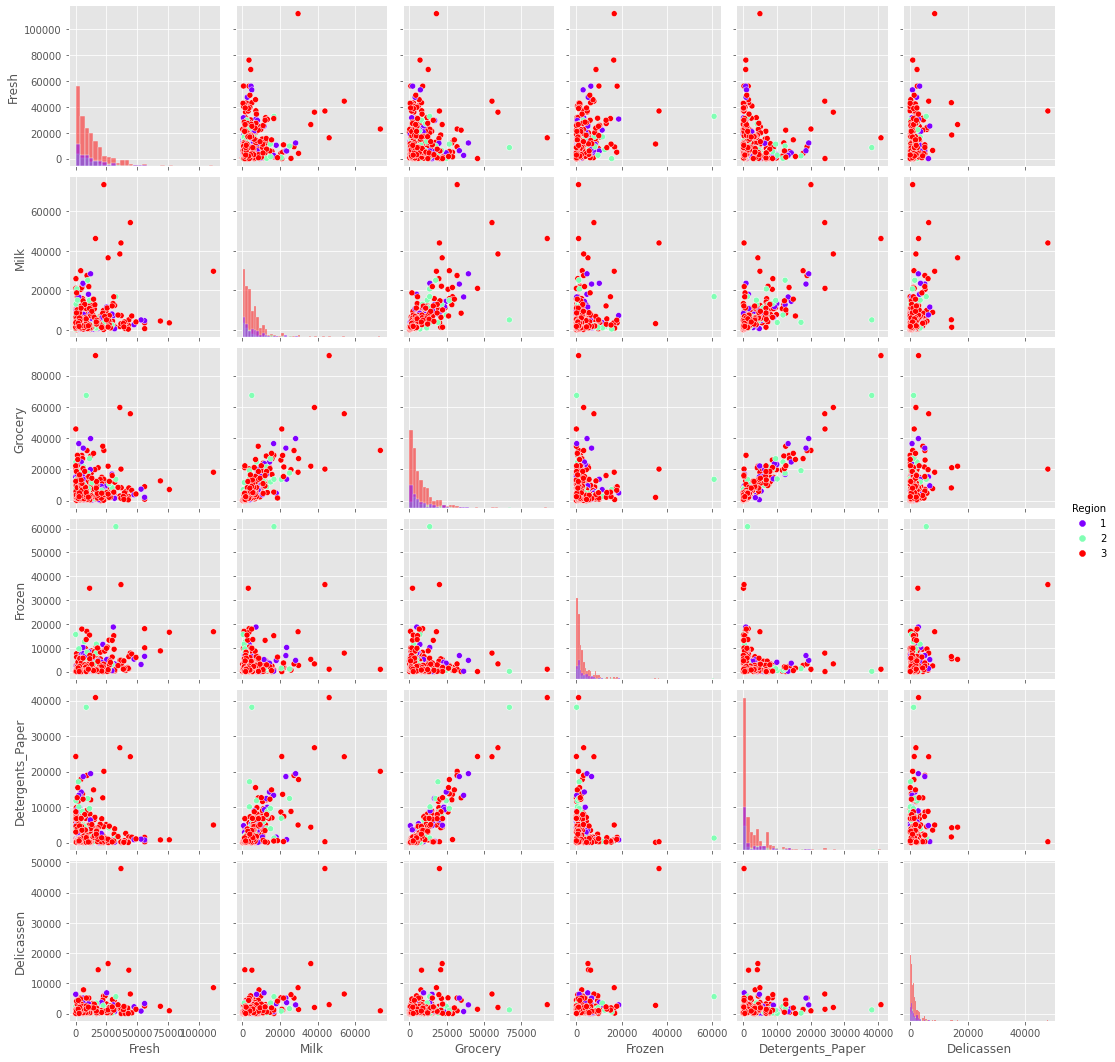

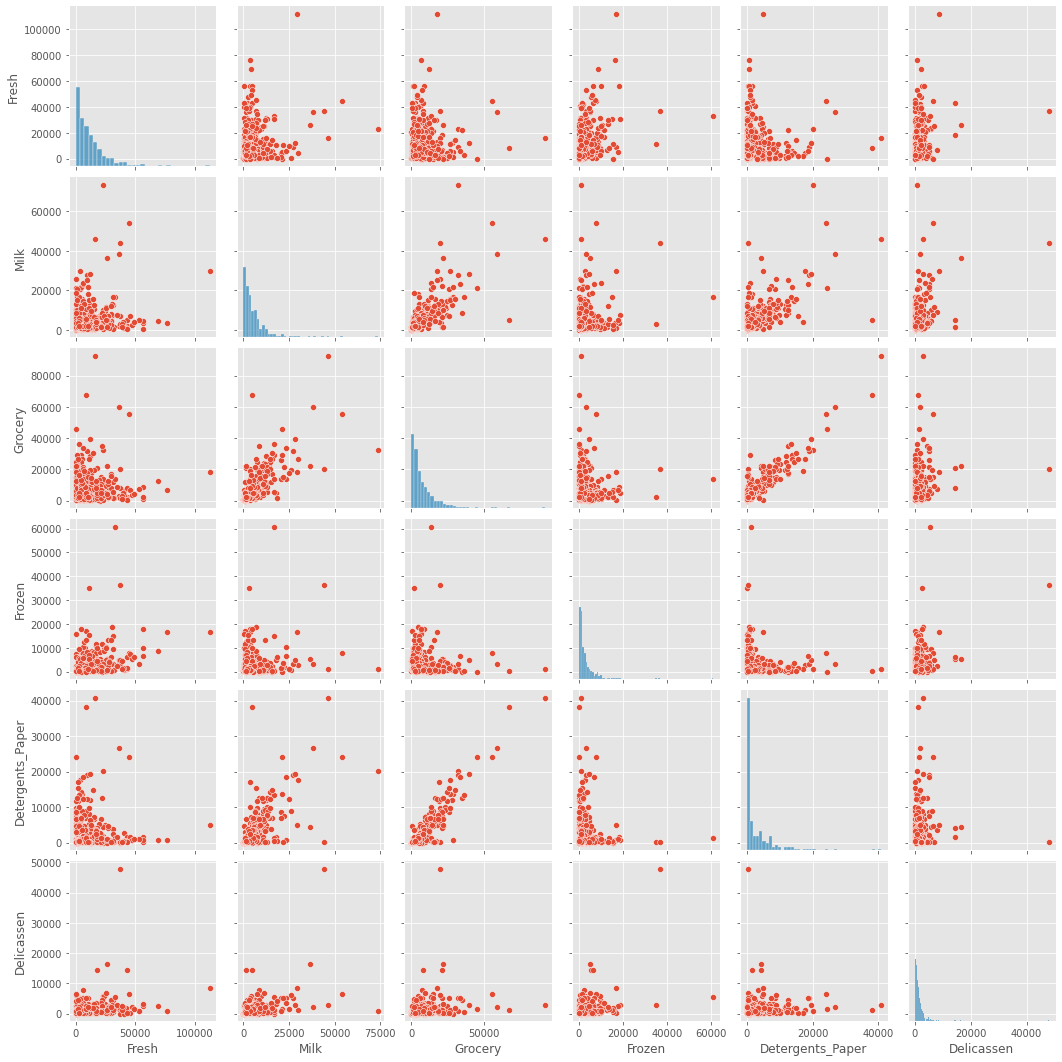

In [12]:
#相関係数
display(df_wholesale.corr())

#散布図行列を作成
# sns.pairplot(df_wholesale, diag_kind="hist");
sns.pairplot(df_wholesale.drop("Region", axis=1), hue="Channel", diag_kind="hist", palette="rainbow");
sns.pairplot(df_wholesale.drop("Channel", axis=1), hue="Region", diag_kind="hist", palette="rainbow");
sns.pairplot(df_wholesale.iloc[:, 2:], diag_kind="hist", palette="rainbow");

In [13]:
print("Channel:")
unique_list, unique_count = np.unique(df_y.iloc[:, 0], return_counts=True)
print(unique_list)
print(unique_count)
print("Region:")
unique_list, unique_count = np.unique(df_y.iloc[:, 1], return_counts=True)
print(unique_list)
print(unique_count)

pd.set_option("display.max_columns", 300)   #列数の表示上限を指定
display(df_wholesale.groupby(["Channel", "Region"]).mean())
display(df_wholesale.groupby(["Region", "Channel"]).mean())

Channel:
[1 2]
[298 142]
Region:
[1 2 3]
[ 77  47 316]


Fresh          Milk       Grocery       Frozen  \
Channel Region                                                          
1       1       12902.254237   3870.203390   4026.135593  3127.322034   
        2       11650.535714   2304.250000   4395.500000  5745.035714   
        3       13878.052133   3486.981043   3886.734597  3656.900474   
2       1        5200.000000  10784.000000  18471.944444  2584.111111   
        2        7289.789474   9190.789474  16326.315789  1540.578947   
        3        9831.504762  10981.009524  15953.809524  1513.200000   

                Detergents_Paper   Delicassen  
Channel Region                                 
1       1             950.525424  1197.152542  
        2             482.714286  1105.892857  
        3             786.682464  1518.284360  
2       1            8225.277778  1871.944444  
        2            8410.263158  1239.000000  
        3            6899.238095  1826.209524

Fresh          Milk       Grocery       Frozen  \
Region Channel                                                          
1      1        12902.254237   3870.203390   4026.135593  3127.322034   
       2         5200.000000  10784.000000  18471.944444  2584.111111   
2      1        11650.535714   2304.250000   4395.500000  5745.035714   
       2         7289.789474   9190.789474  16326.315789  1540.578947   
3      1        13878.052133   3486.981043   3886.734597  3656.900474   
       2         9831.504762  10981.009524  15953.809524  1513.200000   

                Detergents_Paper   Delicassen  
Region Channel                                 
1      1              950.525424  1197.152542  
       2             8225.277778  1871.944444  
2      1              482.714286  1105.892857  
       2             8410.263158  1239.000000  
3      1              786.682464  1518.284360  
       2             6899.238095  1826.209524

#### ・各変数の説明
```
1）FRESH(フレッシュ)：フレッシュ製品への年間支出
2）MILK(ミルク)：乳製品への年間支出
3）GROCERY(食料品)：食料品への年間支出
4）FROZEN(冷凍)：冷凍製品への年間支出
5）DETERGENTS_PAPER(洗剤紙)：洗剤および紙製品への年間支出
6）DELICATESSEN(デリカテッセン)：製品およびデリカテッセン製品への年間支出
7）CHANNEL(チャネル)：customersâ€™チャネル-Horeca（ホテル/レストラン/カフェ）または小売チャネル
8）REGION(地域)：顧客-地域-Lisnon、Oportoまたはその他
```

#### ・主成分分析(PCA)

var_exp(各主成分の因子寄与率):
[0.45961362 0.40517227 0.07003008 0.04402344 0.01502212 0.00613848]
cum_var_exp(因子寄与率の累積):
[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


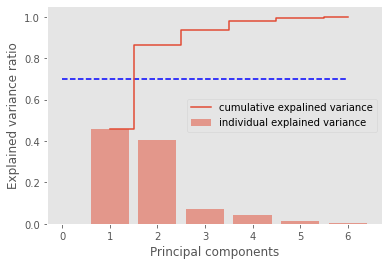

In [14]:
# 主成分分析

X = df_X
y = df_y

# 主成分分析の次数に対する因子寄与率をプロット
pca = PCA(n_components=None)
pca = pca.fit(X)
var_exp = pca.explained_variance_ratio_
print("var_exp(各主成分の因子寄与率):")
print(var_exp)
cum_var_exp = np.cumsum(var_exp)
print("cum_var_exp(因子寄与率の累積):")
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [15]:
X = df_X
y = df_y

# 第二主成分まで次元削減
pca = PCA(n_components = 2)
pca = pca.fit(X)
X_pca = pca.transform(X)

df_X_pca = pd.DataFrame(X_pca, index=X.index, columns=["PC1", "PC2"])
df_X_pca_y0 = pd.concat([df_X_pca, y.iloc[:, 0]], axis=1)
df_X_pca_y1 = pd.concat([df_X_pca, y.iloc[:, 1]], axis=1)

display(df_X_pca_y0)
display(df_X_pca_y1)

,PC1,PC2,Channel
0,650.022122,1585.519090,2
1,-4426.804979,4042.451509,2
2,-4841.998707,2578.762176,2
3,990.346437,-6279.805997,1
4,10657.998731,-2159.725815,2
...,...,...,...
435,20140.848493,6306.877227,1
436,25912.249945,-11757.647107,1
437,4555.114999,26201.758603,2
438,-2734.370920,-7070.775335,1


,PC1,PC2,Region
0,650.022122,1585.519090,3
1,-4426.804979,4042.451509,3
2,-4841.998707,2578.762176,3
3,990.346437,-6279.805997,3
4,10657.998731,-2159.725815,3
...,...,...,...
435,20140.848493,6306.877227,3
436,25912.249945,-11757.647107,3
437,4555.114999,26201.758603,3
438,-2734.370920,-7070.775335,3


,PC1,PC2,Channel
PC1,1.000000e+00,-1.359568e-16,-0.115325
PC2,-1.359568e-16,1.000000e+00,0.625972
Channel,-1.153249e-01,6.259715e-01,1.000000


,PC1,PC2,Region
PC1,1.000000e+00,-1.359568e-16,0.055225
PC2,-1.359568e-16,1.000000e+00,0.008963
Region,5.522516e-02,8.962802e-03,1.000000


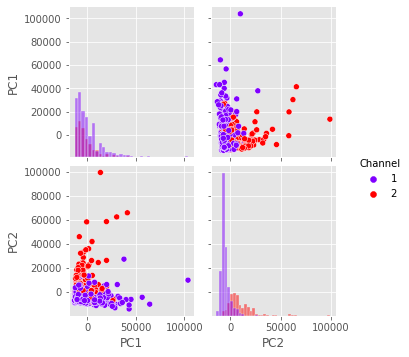

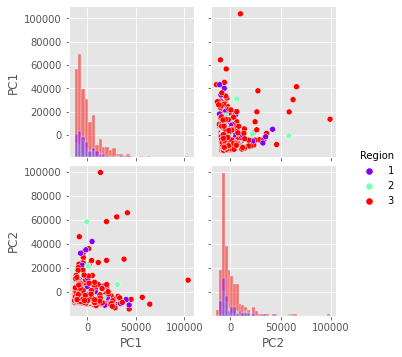

In [16]:
#相関係数
display(df_X_pca_y0.corr())
display(df_X_pca_y1.corr())

#散布図行列を作成
# sns.pairplot(df_X_pca_y0, diag_kind="hist", palette="rainbow");
sns.pairplot(df_X_pca_y0, hue="Channel", diag_kind="hist", palette="rainbow");
# sns.pairplot(df_X_pca_y1, diag_kind="hist", palette="rainbow");
sns.pairplot(df_X_pca_y1, hue="Region", diag_kind="hist", palette="rainbow");

### ●ScratchKMeansクラスによるクラスタリング

#### ・各クラスタ数におけるSSEをプロット

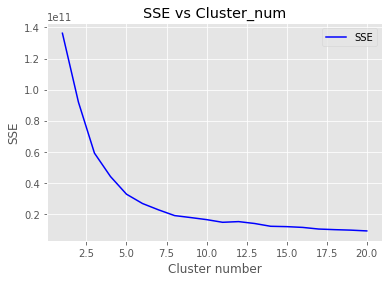

In [32]:
X = X_pca

np.set_printoptions(threshold=10)    #ndarrayの要素の表示数上限を設定

# クラスタ数を1～20まで変化させ、それぞれのSSEをグラフにプロット
plot_sse_vs_cluster_num(X, n_clusters_max=20, n_init=5, max_iter=10, tol=10, random_state=0, verbose=False)

上記のグラフから、クラスタ数を5および9に設定した時にSSEが著しく下がることが確認できたので、以降ではこの２つのクラスタ数に設定してクラスタリングしてみる。

#### ・クラスタ数: 9

y_predict
[2 0 0 ... 1 2 8]
y_predict_list
[0 1 2 3 4 5 6 7 8]
y_predict_count
[ 67  19 103   5  65  24  46   6 105]




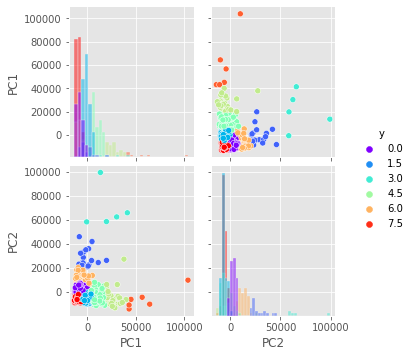

In [29]:
clf = ScratchKMeans(n_clusters=9, n_init=5, max_iter=10, tol=10, random_state=0, verbose=False)

X = X_pca

# 学習, 推定
clf.fit(X)
y_predict = clf.cluster_num
y_predict_list, y_predict_count = np.unique(y_predict, return_counts=True)
print("y_predict")
print(y_predict)
print("y_predict_list")
print(y_predict_list)
print("y_predict_count")
print(y_predict_count)
print("\n")

# Xtとytを結合してDataFrame化
X_y_predict = np.concatenate([X, y_predict.reshape(y_predict.shape[0], 1)], axis=1)
df_X_y_predict = pd.DataFrame(data=X_y_predict, columns=["PC1", "PC2", "y"])

# 散布図行列を作成
# sns.pairplot(df_X_y_predict, diag_kind="hist", palette="rainbow");
sns.pairplot(df_X_y_predict, hue="y", diag_kind="hist", palette="rainbow");

# # 散布図を作成
# df = df_X_y_predict
# plt.figure()
# for i in np.unique(y_predict):
#     plt.scatter(df[df.loc[:, "y"] == i].loc[:, "PC1"], df[df.loc[:, "y"]== i].loc[:, "PC2"], label=i)
# # plt.title()
# plt.xlabel("PC1"); plt.ylabel('PC2');
# plt.legend(loc='best') # 凡例を表示
# plt.tight_layout(h_pad = 2.5)

#### ・クラスタ数: 5

y_predict
[4 0 2 ... 0 2 2]
y_predict_list
[0 1 2 3 4]
y_predict_count
[ 86  10 205  26 113]




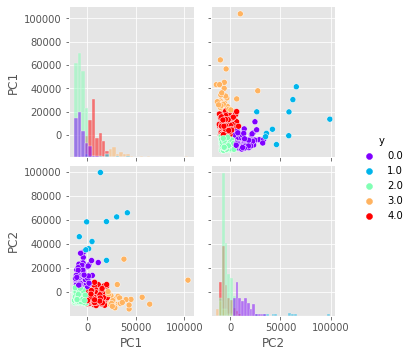

In [30]:
clf = ScratchKMeans(n_clusters=5, n_init=5, max_iter=10, tol=10, random_state=0, verbose=False)

X = X_pca

# 学習, 推定
clf.fit(X)
y_predict = clf.cluster_num
y_predict_list, y_predict_count = np.unique(y_predict, return_counts=True)
print("y_predict")
print(y_predict)
print("y_predict_list")
print(y_predict_list)
print("y_predict_count")
print(y_predict_count)
print("\n")

# Xtとytを結合してDataFrame化
X_y_predict = np.concatenate([X, y_predict.reshape(y_predict.shape[0], 1)], axis=1)
df_X_y_predict = pd.DataFrame(data=X_y_predict, columns=["PC1", "PC2", "y"])

# 散布図行列を作成
# sns.pairplot(df_X_y_predict, diag_kind="hist", palette="rainbow");
sns.pairplot(df_X_y_predict, hue="y", diag_kind="hist", palette="rainbow");

# # 散布図を作成
# df = df_X_y_predict
# plt.figure()
# for i in np.unique(y_predict):
#     plt.scatter(df[df.loc[:, "y"] == i].loc[:, "PC1"], df[df.loc[:, "y"]== i].loc[:, "PC2"], label=i)
# # plt.title()
# plt.xlabel("PC1"); plt.ylabel('PC2');
# plt.legend(loc='best') # 凡例を表示
# plt.tight_layout(h_pad = 2.5)

### 【問題10 解答】
クラスタ数を5と9の2通り散布図を作成したところ、クラスタ数=9の場合はクラスタリングが細かすぎである。クラスタ数＝５の場合のほうが適度にクラスタリングできているので、以降では基本的にクラスタ数を5に設定して分析を行う。

## 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

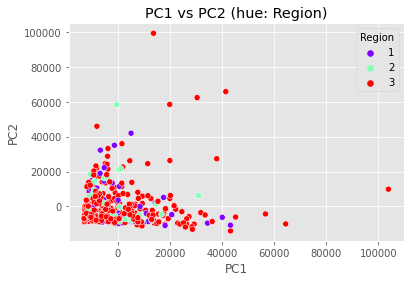

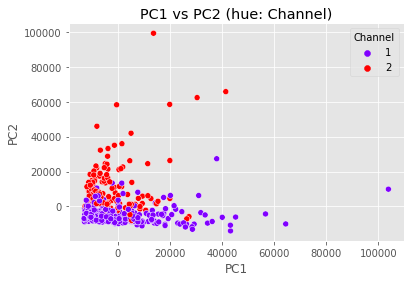

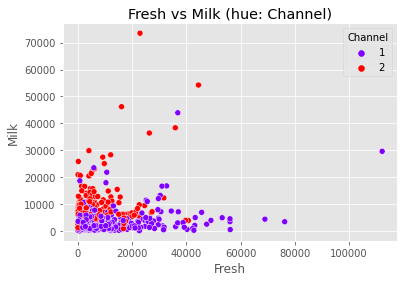

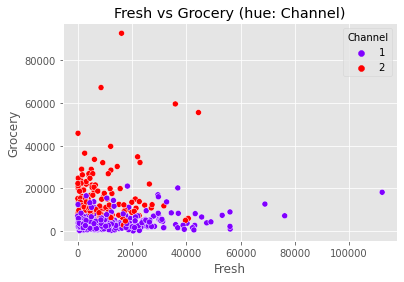

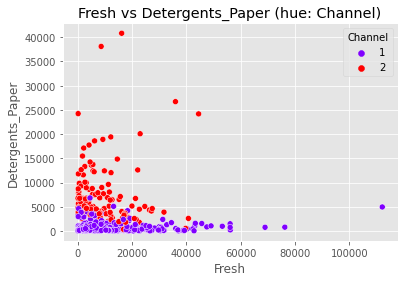

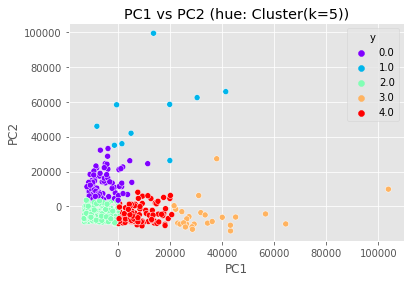

In [31]:
# 散布図行列を作成
plt.figure()
plt.title("PC1 vs PC2 (hue: Region)")
sns.scatterplot(data=df_X_pca_y1, x="PC1", y="PC2", hue="Region", palette="rainbow");

plt.figure()
plt.title("PC1 vs PC2 (hue: Channel)")
sns.scatterplot(data=df_X_pca_y0, x="PC1", y="PC2", hue="Channel", palette="rainbow");

plt.figure()
plt.title("Fresh vs Milk (hue: Channel)")
sns.scatterplot(data=df_wholesale, x="Fresh", y="Milk", hue="Channel", palette="rainbow");

plt.figure()
plt.title("Fresh vs Grocery (hue: Channel)")
sns.scatterplot(data=df_wholesale, x="Fresh", y="Grocery", hue="Channel", palette="rainbow");

plt.figure()
plt.title("Fresh vs Detergents_Paper (hue: Channel)")
sns.scatterplot(data=df_wholesale, x="Fresh", y="Detergents_Paper", hue="Channel", palette="rainbow");

plt.figure()
plt.title("PC1 vs PC2 (hue: Cluster(k=5))")
sns.scatterplot(data=df_X_y_predict, x="PC1", y="PC2", hue="y", palette="rainbow");

### 【問題11 解答】
各主成分の値が大きいデータ点についてはRegion=3のものが多いが、それ以外はRegion1～3の間では分布の傾向に大きな違いは見られなかったので、クラスタリングに使用するのには向いていない。
<br><br>
一方、Channel1と2の間にはデータの分布に偏りの違いが見られ、第一主成分が大きくなるほどChannel1の割合が増え、第二主成分が大きくなるほどChannel2の割合が増大した。この傾向やデータ分布の形は、FreshとMilk/Grocery/Detergents_Paperとの各散布図の形と類似しており、このことから主成分分析では主にこれらの特徴量の分散の傾向を反映していることがわかる。
<br><br>
今回ScratchKMeansクラスにより5つのクラスタにクラスタリングした結果は、このChannel1と2をさらに細分化したものであると言える。

## 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

《ヒント》


前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。


条件ごとにデータを見る際にはPandasのgroupbyが便利です。

### ●ScratchKMeansクラスによるクラスタリング

#### ・データセット：オリジナル（PCA実施前）

In [21]:
# オリジナルのデータセットXの中身
display(df_X)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


#### ・クラスタリング(特徴量: 全て使用)

y_predict
[0 2 0 ... 2 0 0]
y_predict_list
[0 1 2 3 4]
y_predict_count
[209  11  94 103  23]




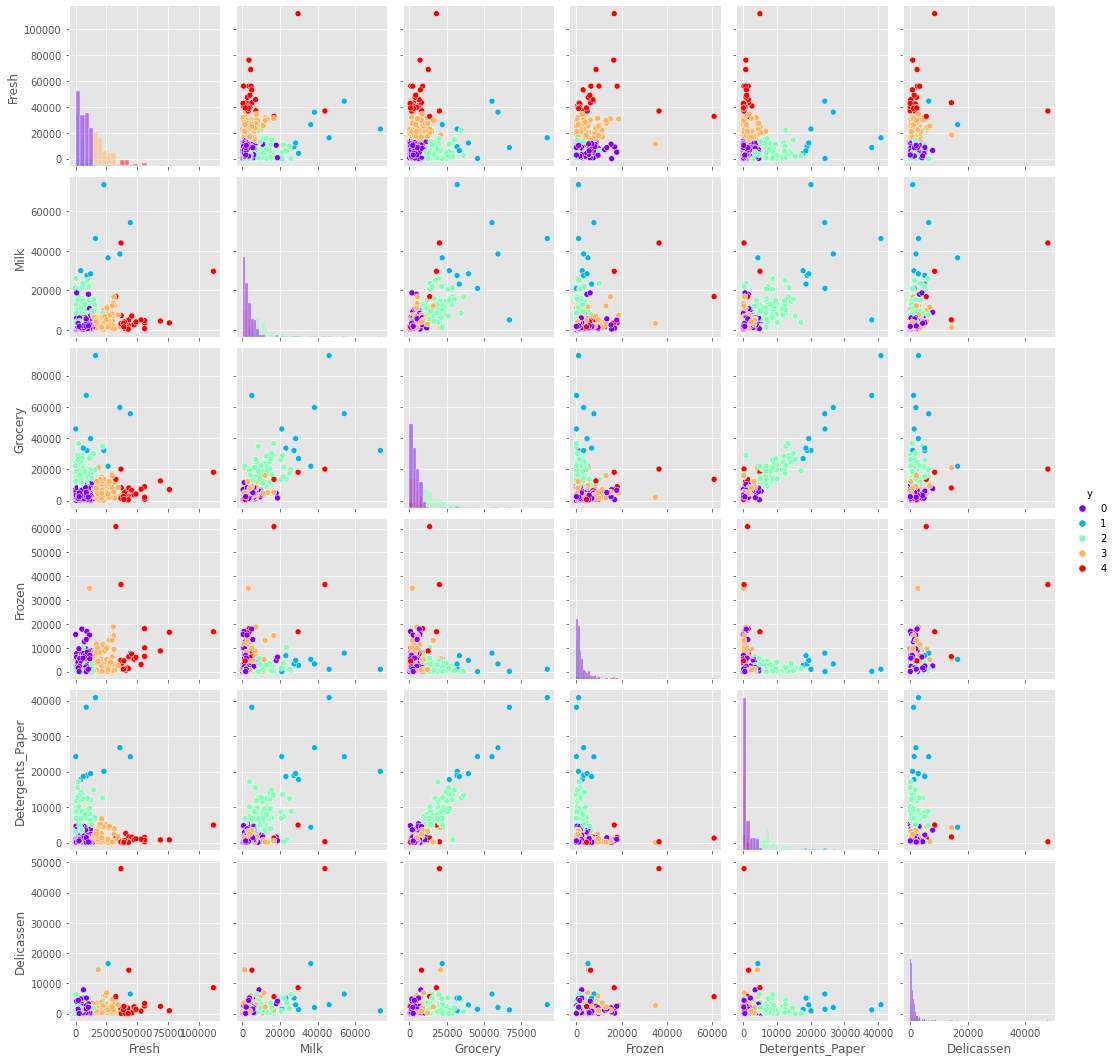

In [22]:
clf = ScratchKMeans(n_clusters=5, n_init=5, max_iter=10, tol=10, random_state=0, verbose=False)

X = np.array(df_X)

# 学習, 推定
clf.fit(X)
y_predict = clf.cluster_num
y_predict_list, y_predict_count = np.unique(y_predict, return_counts=True)
print("y_predict")
print(y_predict)
print("y_predict_list")
print(y_predict_list)
print("y_predict_count")
print(y_predict_count)
print("\n")

# Xtとytを結合してDataFrame化
X_y_predict = np.concatenate([X, y_predict.reshape(y_predict.shape[0], 1)], axis=1)
df_X_y_predict = pd.DataFrame(data=X_y_predict, columns=[*df_X.columns, "y"])

# 散布図行列を作成
# sns.pairplot(df_X_y_predict, diag_kind="hist", palette="rainbow");
sns.pairplot(df_X_y_predict, hue="y", diag_kind="hist", palette="rainbow");

# # 散布図を作成
# df = df_X_y_predict
# plt.figure()
# for i in np.unique(y_predict):
#     plt.scatter(df[df.loc[:, "y"] == i].loc[:, "PC1"], df[df.loc[:, "y"]== i].loc[:, "PC2"], label=i)
# # plt.title()
# plt.xlabel("PC1"); plt.ylabel('PC2');
# plt.legend(loc='best') # 凡例を表示
# plt.tight_layout(h_pad = 2.5)

#### ・クラスタリング(特徴量: FrozenとDelicassenを除外)

y_predict
[0 2 0 ... 2 0 0]
y_predict_list
[0 1 2 3 4]
y_predict_count
[210  12  91 105  22]




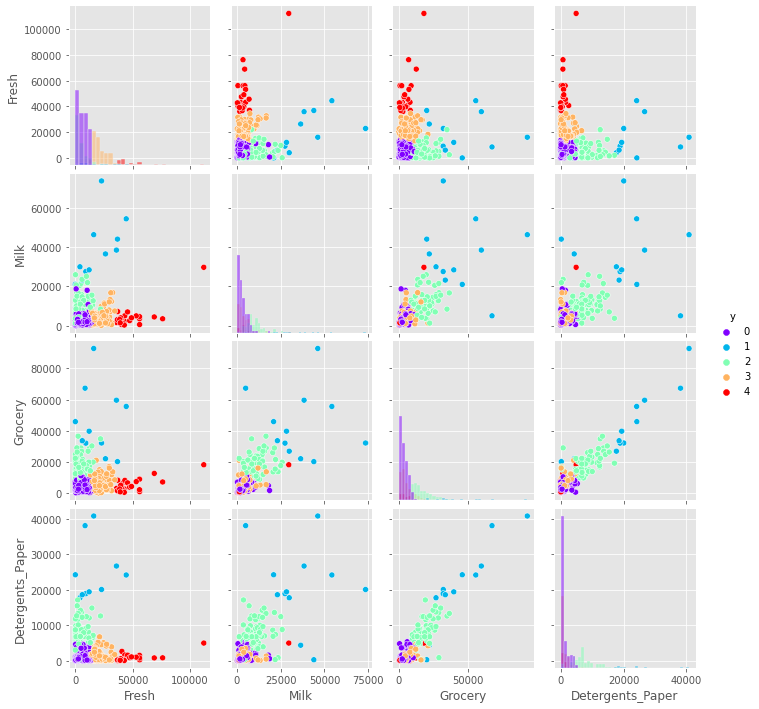

In [23]:
clf = ScratchKMeans(n_clusters=5, n_init=5, max_iter=10, tol=10, random_state=0, verbose=False)

column_list = ["Fresh", "Milk", "Grocery", "Detergents_Paper"]
X = np.array(df_X.loc[:, column_list])

# 学習, 推定
clf.fit(X)
y_predict = clf.cluster_num
y_predict_list, y_predict_count = np.unique(y_predict, return_counts=True)
print("y_predict")
print(y_predict)
print("y_predict_list")
print(y_predict_list)
print("y_predict_count")
print(y_predict_count)
print("\n")

# Xtとytを結合してDataFrame化
X_y_predict = np.concatenate([X, y_predict.reshape(y_predict.shape[0], 1)], axis=1)
df_X_y_predict = pd.DataFrame(data=X_y_predict, columns=[*column_list, "y"])

# 散布図行列を作成
# sns.pairplot(df_X_y_predict, diag_kind="hist");
sns.pairplot(df_X_y_predict, hue="y", diag_kind="hist", palette="rainbow");

# # 散布図を作成
# df = df_X_y_predict
# plt.figure()
# for i in np.unique(y_predict):
#     plt.scatter(df[df.loc[:, "y"] == i].loc[:, "PC1"], df[df.loc[:, "y"]== i].loc[:, "PC2"], label=i)
# # plt.title()
# plt.xlabel("PC1"); plt.ylabel('PC2');
# plt.legend(loc='best') # 凡例を表示
# plt.tight_layout(h_pad = 2.5)

### 【問題12 解答】
オリジナルのデータセットの全ての特徴量を対象にクラスタリングを行ったところ、特徴量の内、Fresh、Milk、Grocery、Detergents_Paperにおいてクラスタが形成されており、特にMilkとGroceryとDetergents_Paperは互いに相関が大きく、３つのクラスタに分かれている。これらはChannel2（小売店）での販売が主である。
一方、Freshは上記３種の特徴量とは別の３つのクラスタが形成されており、Channel1（レストラン/ホテル等）で高い売り上げが記録されている。
<br><br>
以上から、MilkとGroceryとDetergents_Paperについては小売店向けに低価格/中価格/高価格の３種類のバリエーションを展開し、Freshについてはレストラン/ホテル向けに低価格/中価格/高価格のバリエーション展開を行うことで各顧客層に合致した商品の提供が行え、売上増加に繋げられる可能性がある。
